The following code describes first learning the images without training the base model and than fine tuning and retrain the model after open the base model's layers to train.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import random
import keras as ks
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Input,GlobalAveragePooling2D, Flatten, Dense, BatchNormalization, Dropout, GlobalMaxPooling2D, Conv2D
from tensorflow.keras.applications import DenseNet121
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers ,Model
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from keras.utils import to_categorical
import os.path

Mounted at /content/gdrive


In [ ]:
import keras as ks
import tensorflow as tf
print(tf.__version__)
print(ks.__version__)

2.12.0
2.12.0


folders:

In [ ]:
PATH_TEST_0 = "/content/gdrive/MyDrive/mini-project/breast_cancer_data/data/TEST/0"
PATH_TEST_1 = "/content/gdrive/MyDrive/mini-project/breast_cancer_data/data/TEST/1"
PATH_VAL_0 = "/content/gdrive/MyDrive/mini-project/breast_cancer_data/data/VAL/0"
PATH_VAL_1 = "/content/gdrive/MyDrive/mini-project/breast_cancer_data/data/VAL/1"
PATH_TRAIN_0 = "/content/gdrive/MyDrive/mini-project/breast_cancer_data/data/TRAIN/0"
PATH_TRAIN_1 = "/content/gdrive/MyDrive/mini-project/breast_cancer_data/data/TRAIN/1"

In [ ]:
test_0 = len(os.listdir(PATH_TEST_0))
print(f"Folder test_0: {test_0}")

test_1 = len(os.listdir(PATH_TEST_1))
print(f"Folder test_1: {test_1}")

train_0 = len(os.listdir(PATH_TRAIN_0))
print(f"Folder train_0: {train_0}")

train_1 = len(os.listdir(PATH_TRAIN_1))
print(f"Folder train_1: {train_1}")

validation_0 = len(os.listdir(PATH_VAL_0))
print(f"Folder val_0: {validation_0}")

validation_1 = len(os.listdir(PATH_VAL_1))
print(f"Folder val_1: {validation_1}")

Folder test_0: 900
Folder test_1: 300
Folder train_0: 29769
Folder train_1: 10645
Folder val_0: 300
Folder val_1: 100


train and validation generator (including augmentation):

In [ ]:
img_width, img_height = 50, 50
train_data_dir = '/content/gdrive/MyDrive/mini-project/breast_cancer_data/data/TRAIN'
validation_data_dir = '/content/gdrive/MyDrive/mini-project/breast_cancer_data/data/VAL'

BATCH_SIZE = 64
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           featurewise_center=False,  # set input mean to 0 over the dataset
                                          samplewise_center=False,  # set each sample mean to 0
                                          featurewise_std_normalization=False,  # divide inputs by std of the dataset
                                          samplewise_std_normalization=False,  # divide each input by its std
                                          zca_whitening=False,  # apply ZCA whitening
                                          rotation_range=20,# randomly rotate images in the range (degrees, 0 to 180)
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
                                          height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
                                          fill_mode='constant',  # fill shifted pixels with a constant value
                                          cval=0,  # set the constant value to 0 (black)
                                          horizontal_flip=True,  # randomly flip images
                                          vertical_flip=True)  # Generator for our training datavalidation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data


train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_data_dir,
                                                           shuffle=True,
                                                           target_size=(img_width,img_height), #(50,50)
                                                           class_mode='categorical')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                             directory=validation_data_dir,
                                                             shuffle=False,
                                                             target_size=(img_width,img_height), #(50,50)
                                                             class_mode='categorical')

Found 40414 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


#first train:

In [ ]:
base_model = DenseNet121(
            weights='imagenet',  # Load weights pre-trained on ImageNet.
            include_top=False)   # Do not include the ImageNet classifier at the top.
# Freeze all layers in the base model.
for layer in base_model.layers:
    layer.trainable = False

    # top layer architecture
inputs = Input(shape=(img_width,img_height,3))
x1 = base_model(inputs, training=False)
x2 = GlobalAveragePooling2D()(x1)
x3 = Dense(256, activation = 'relu')(x2)
x4= Dropout(0.2)(x3)
x5 = Dense(128, activation = 'relu')(x4)
x6 = Dense(64, activation = 'relu')(x5)
outputs = Dense(2, activation='softmax')(x6)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.AUC()])

print(model.summary())

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896  

train:

We used checkpoint to save the best model during the training as well as earlystopping to stop the training if there is no progress in the results

In [ ]:
# Define callbacks
checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/mini-project/checkpoints/breast/final_model_1.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

EPOCHS = 20
nb_train_samples =40414
nb_validation_samples = 400
class_weight = {0: 1.,
                1: 2.8}
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(nb_train_samples / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(nb_validation_samples / float(BATCH_SIZE))),
    callbacks=[checkpoint,early_stopping],
    class_weight=class_weight
)

Epoch 1/20
632/632 [==============================] - ETA: 0s - loss: 0.7016 - accuracy: 0.7790 - auc: 0.8539 
Epoch 1: val_accuracy improved from -inf to 0.69250, saving model to /content/gdrive/MyDrive/mini-project/checkpoints/breast/final_model_1.h5
632/632 [==============================] - 10022s 16s/step - loss: 0.7016 - accuracy: 0.7790 - auc: 0.8539 - val_loss: 0.5541 - val_accuracy: 0.6925 - val_auc: 0.8026
Epoch 2/20
632/632 [==============================] - ETA: 0s - loss: 0.6632 - accuracy: 0.7959 - auc: 0.8703
Epoch 2: val_accuracy did not improve from 0.69250
632/632 [==============================] - 124s 196ms/step - loss: 0.6632 - accuracy: 0.7959 - auc: 0.8703 - val_loss: 0.5404 - val_accuracy: 0.6875 - val_auc: 0.8119
Epoch 3/20
632/632 [==============================] - ETA: 0s - loss: 0.6488 - accuracy: 0.7947 - auc: 0.8753
Epoch 3: val_accuracy did not improve from 0.69250
632/632 [==============================] - 115s 181ms/step - loss: 0.6488 - accuracy: 0.794

Model evaluation:

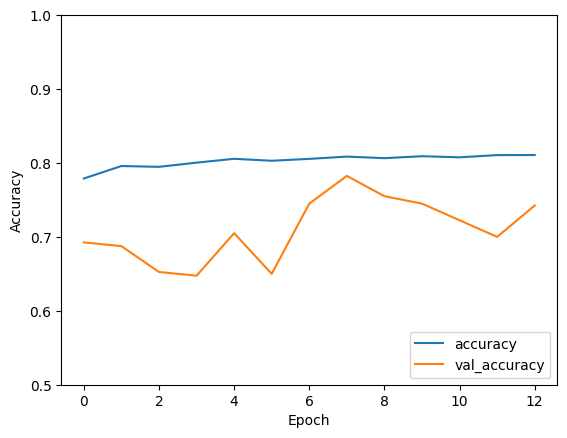

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

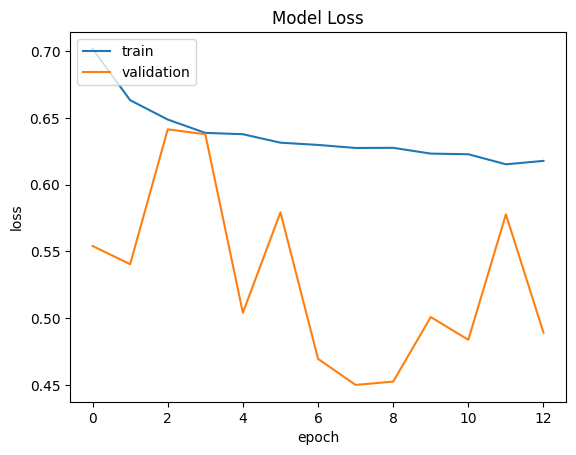

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



Checking on the test with the best model we got from the first training

In [ ]:
model = models.load_model('/content/gdrive/MyDrive/mini-project/checkpoints/breast/final_model_1.h5')

img_width, img_height = 50, 50
test_data_dir = '/content/gdrive/MyDrive/mini-project/breast_cancer_data/data/TEST'

BATCH_SIZE = 16 #גודל אצווה
test_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our testing data

test_data_gen = test_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=test_data_dir,
                                                           shuffle=False,
                                                           target_size=(img_width,img_height), #(50,50)
                                                           class_mode='categorical')

Found 1200 images belonging to 2 classes.


In [ ]:
from sklearn.metrics import classification_report
Y_pred = model.predict(test_data_gen, test_data_gen.samples / BATCH_SIZE)
val_preds = np.argmax(Y_pred, axis=1)
val_trues =test_data_gen.classes
print(classification_report(val_trues, val_preds))

75/75 [==============================] - 73s 960ms/step
              precision    recall  f1-score   support

           0       0.92      0.72      0.81       900
           1       0.49      0.82      0.62       300

    accuracy                           0.74      1200
   macro avg       0.71      0.77      0.71      1200
weighted avg       0.82      0.74      0.76      1200



In [ ]:
import sklearn.metrics as metrics
Y_pred = model.predict(test_data_gen, test_data_gen.samples/BATCH_SIZE)
val_preds = np.argmax(Y_pred, axis=1)
val_trues = test_data_gen.classes
CM = metrics.confusion_matrix(val_trues, val_preds)
print(CM)

75/75 [==============================] - 3s 43ms/step
[[646 254]
 [ 53 247]]


In [ ]:
from sklearn.metrics import roc_auc_score
Y_pred = model.predict(test_data_gen, test_data_gen.samples / BATCH_SIZE)
auc_score = roc_auc_score(val_trues, Y_pred[:, 1])  # Assuming the positive class is at index 1
print("AUC Score:", auc_score)

75/75 [==============================] - 3s 33ms/step
AUC Score: 0.8445407407407407


#fine tuning

For the fine tuning we lowered the LR by one order of magnitude and opened the layers of the base model for training

In [ ]:
# load the saved model
model = models.load_model('/content/gdrive/MyDrive/mini-project/checkpoints/breast/final_model_1.h5')

for layer in model.get_layer("densenet121").layers:
    layer.trainable = True

print(model.summary())
opt = tf.keras.optimizers.Adam(0.0001)
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy',AUC()])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                             

In [ ]:
BATCH_SIZE = 128
# Define callbacks
checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/mini-project/checkpoints/breast/final_model_2.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', patience=6)

EPOCHS = 10
nb_train_samples =40414
nb_validation_samples = 400
class_weight = {0: 1.,
                1: 2.8}
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(nb_train_samples / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(nb_validation_samples / float(BATCH_SIZE))),
    callbacks=[checkpoint, early_stopping],
    class_weight=class_weight
)

Epoch 1/10
316/316 [==============================] - ETA: 0s - loss: 0.6489 - accuracy: 0.8063 - auc: 0.8776 
Epoch 1: val_accuracy improved from -inf to 0.68750, saving model to /content/gdrive/MyDrive/mini-project/checkpoints/breast/final_model_2.h5
316/316 [==============================] - 4136s 13s/step - loss: 0.6489 - accuracy: 0.8063 - auc: 0.8776 - val_loss: 0.6018 - val_accuracy: 0.6875 - val_auc: 0.7634
Epoch 2/10
316/316 [==============================] - ETA: 0s - loss: 0.5970 - accuracy: 0.8211 - auc: 0.8955
Epoch 2: val_accuracy improved from 0.68750 to 0.88672, saving model to /content/gdrive/MyDrive/mini-project/checkpoints/breast/final_model_2.h5
316/316 [==============================] - 2065s 7s/step - loss: 0.5970 - accuracy: 0.8211 - auc: 0.8955 - val_loss: 0.2459 - val_accuracy: 0.8867 - val_auc: 0.9723
Epoch 3/10
316/316 [==============================] - ETA: 0s - loss: 0.5643 - accuracy: 0.8267 - auc: 0.9069
Epoch 3: val_accuracy improved from 0.88672 to 0.96

Model evaluation:

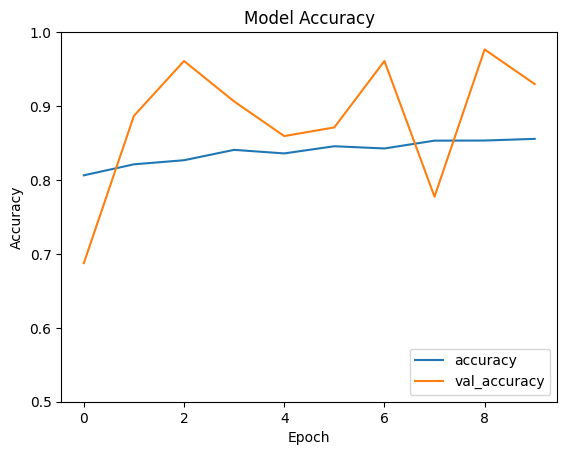

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

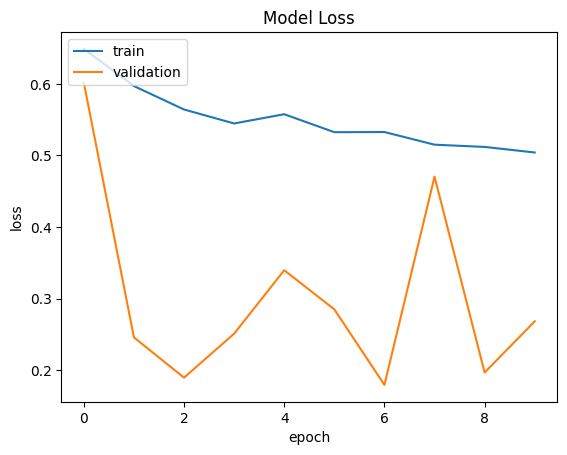

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

rechecking the model on the test data:

In [ ]:
model = models.load_model('/content/gdrive/MyDrive/mini-project/checkpoints/breast/final_model_2.h5')

img_width, img_height = 50, 50 #הגדרת גודל תמונות אחיד
test_data_dir = '/content/gdrive/MyDrive/mini-project/breast_cancer_data/data/TEST'

BATCH_SIZE = 16
test_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our testing data

test_data_gen = test_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=test_data_dir,
                                                           shuffle=False,
                                                           target_size=(img_width,img_height), #(50,50)
                                                           class_mode='categorical')

Found 1200 images belonging to 2 classes.


In [ ]:
from sklearn.metrics import classification_report
Y_pred = model.predict(test_data_gen, test_data_gen.samples / BATCH_SIZE)
val_preds = np.argmax(Y_pred, axis=1)
val_trues =test_data_gen.classes
print(classification_report(val_trues, val_preds))

75/75 [==============================] - 244s 3s/step
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       900
           1       0.57      0.69      0.62       300

    accuracy                           0.79      1200
   macro avg       0.73      0.76      0.74      1200
weighted avg       0.81      0.79      0.80      1200



In [ ]:
import sklearn.metrics as metrics
Y_pred = model.predict(test_data_gen, test_data_gen.samples/BATCH_SIZE)
val_preds = np.argmax(Y_pred, axis=1)
val_trues = test_data_gen.classes
CM = metrics.confusion_matrix(val_trues, val_preds)
print(CM)

75/75 [==============================] - 14s 186ms/step
[[744 156]
 [ 93 207]]


In [ ]:
from sklearn.metrics import roc_auc_score
Y_pred = model.predict(test_data_gen, test_data_gen.samples / BATCH_SIZE)
auc_score = roc_auc_score(val_trues, Y_pred[:, 1])  # Assuming the positive class is at index 1
print("AUC Score:", auc_score)

75/75 [==============================] - 14s 180ms/step
AUC Score: 0.8811962962962963
